In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix,classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.applications import ResNet152,EfficientNetB1,DenseNet121,VGG19
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pickle


In [2]:
# Reading the Ground Truth
df = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
df = df.drop(columns='UNK')
# https://challenge.isic-archive.com/data/#2019 for datset
# Creating folders for each category
categories = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevus',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratosis',
    'BKL': 'Benign keratosis',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesion',
    'SCC': 'Squamous cell carcinoma',
}
# Path to the directory containing the image files
image_directory = '/Users/KIIT/Documents/skin_class/ISIC_2019_Training_Input'

# List of all the image files in the directory
actual_files = os.listdir(image_directory)

# List of image files mentioned in the CSV
csv_files = df['image'].apply(lambda x: x + '.jpg').tolist()

# Checking for missing files
missing_files = [file for file in csv_files if file not in actual_files]

if missing_files:
    print("The following files are mentioned in the CSV but are missing in the directory:")
    for file in missing_files:
        print(file)
else:
    print("All files mentioned in the CSV are present in the directory.")
base_path = '/Users/KIIT/Documents/skin_class/ISIC_Labelled'
for category, folder_name in categories.items():
    os.makedirs(os.path.join(base_path, folder_name), exist_ok=True)

# Spliting the images into their respective folders
for index, row in df.iterrows():
    image_name = row['image'] + '.jpg'  # Assuming the images have jpg extension
    for category, folder_name in categories.items():
        if row[category] == 1.0:
            source_path = '/Users/KIIT/Documents/skin_class/ISIC_2019_Training_Input/' + image_name  # Replace with the actual path to your images
            destination_path = os.path.join(base_path, folder_name, image_name)
            shutil.copyfile(source_path, destination_path)

All files mentioned in the CSV are present in the directory.


In [3]:
# Defining the source directory where the image folders are located
source_dir = '/Users/KIIT/Documents/skin_class/ISIC_Labelled/'

# Defining the destination directory to store the training, validation, and test datasets
base_dir = '/Users/KIIT/Documents/skin_class/ISIC_Split/'
os.makedirs(base_dir, exist_ok=True)

# Define the ratio for splitting the data (e.g., 70% training, 15% validation, 15% testing)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define lists to store image paths and corresponding class labels
X = []
y = []

# Iterate through each image folder
for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name)
    images = os.listdir(folder_path)

    for image in images:
        X.append(os.path.join(folder_path, image))
        y.append(folder_name)

# Perform stratified train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_ratio, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(1 - test_ratio), stratify=y_train_val, random_state=42)

# Iterate through each image folder to copy images to respective directories based on the split
for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name)

    # Creating subdirectories for training, validation, and test sets
    train_dir = os.path.join(base_dir, 'train', folder_name)
    val_dir = os.path.join(base_dir, 'validation', folder_name)
    test_dir = os.path.join(base_dir, 'test', folder_name)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    images = os.listdir(folder_path)

    for image in images:
        if os.path.join(folder_path, image) in X_train:
            shutil.copy(os.path.join(folder_path, image), os.path.join(train_dir, image))
        elif os.path.join(folder_path, image) in X_val:
            shutil.copy(os.path.join(folder_path, image), os.path.join(val_dir, image))
        else:
            shutil.copy(os.path.join(folder_path, image), os.path.join(test_dir, image))

In [4]:
# Set the paths to your directories
train_dir = '/Users/KIIT/Documents/skin_class/ISIC_Split/train'
validation_dir = '/Users/KIIT/Documents/skin_class/ISIC_Split/validation'
test_dir = '/Users/KIIT/Documents/skin_class/ISIC_Split/test'

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

Found 17731 images belonging to 8 classes.
Found 3800 images belonging to 8 classes.
Found 3800 images belonging to 8 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 240, 240,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 240, 240,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 240, 240,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 27,549,071 (105.09 MB)

 Trainable params: 27,487,016 (104.85 MB)

 Non-trainable params: 62,055 (242.41 KB)

Epoch 1/16
554/554 ━━━━━━━━━━━━━━━━━━━━ 4867s 9s/step - accuracy: 0.5691 - loss: 6.1905 - val_accuracy: 0.5432 - val_loss: 2.9127 - learning_rate: 0.0010
Epoch 2/16
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6875 - loss: 2.4534 - val_accuracy: 0.4583 - val_loss: 3.2622 - learning_rate: 0.0010
Epoch 3/16
554/554 ━━━━━━━━━━━━━━━━━━━━ 4375s 8s/step - accuracy: 0.6637 - loss: 2.2632 - val_accuracy: 0.6809 - val_loss: 1.4014 - learning_rate: 0.0010
Epoch 4/16
554/554 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7188 - loss: 1.3014 - val_accuracy: 0.7500 - val_loss: 1.2298 - learning_rate: 0.0010
Epoch 5/16
554/554 ━━━━━━━━━━━━━━━━━━━━ 4416s 8s/step - accuracy: 0.7048 - loss: 1.3382 - val_accuracy: 0.6441 - val_loss: 1.3788 - learning_rate: 0.0010
Epoch 6/16
554/554 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7188 - loss: 1.0719 - val_accuracy: 0.5833 - val_loss: 1.6348 - learning_rate: 1.0000e-04
Epoch 7/16
554/554 ━━━━━━━━━━━━━━━━━━━━ 4487s 8s/step - accuracy: 0.7325 - lo

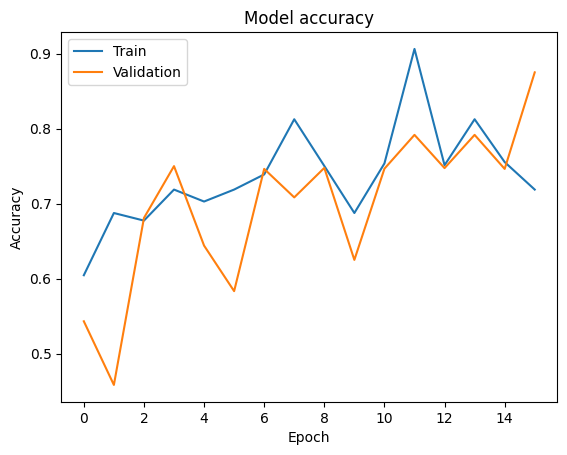

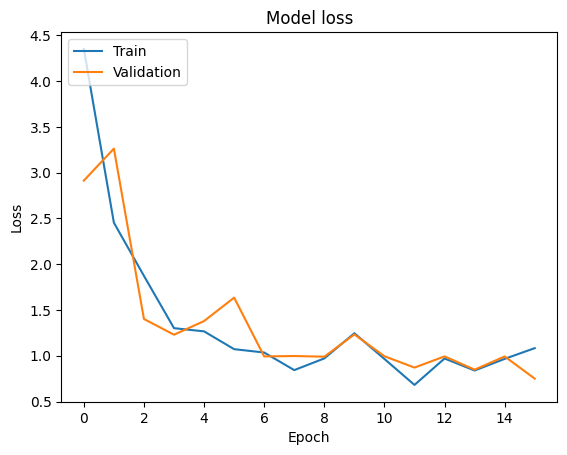

In [9]:
# Learning rate scheduling function
def learning_rate_schedule(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * 0.1
# Load the EfficientNetB1 model
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# UnFreezing the base model
for layer in base_model.layers:
    layer.trainable = True

# Adding custom layers on top
x = base_model.output
x = Flatten()(x)
# Add Dropout for regularization
x = Dropout(0.5)(x)  # 50% dropout rate

# Add Dense layer with L2 regularization
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization

# Output layer
predictions = Dense(8, activation='softmax')(x)  # 8 classes

# Creating the full model
modelen = Model(inputs=base_model.input, outputs=predictions)
# Defining optimizer with initial learning rate
optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  
                               restore_best_weights=True)

modelen.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
# Defining learning rate scheduler callback
learning_rate_scheduler = LearningRateScheduler(learning_rate_schedule)
modelen.summary()
# During model training
history = modelen.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=16,  
    callbacks=[early_stopping, learning_rate_scheduler]
)

# Save the model after training
modelen.save('/Users/KIIT/Documents/skin_class/ENB1_8Class30.h5')
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
test_loss, test_accuracy = modelen.evaluate(test_generator)
print(f'New test loss: {test_loss}')
print(f'New test accuracy: {test_accuracy}')


119/119 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7668 - loss: 0.9610
New test loss: 0.9747660160064697
New test accuracy: 0.7568420767784119


In [24]:
# Learning rate scheduling function
def learning_rate_schedule(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * 0.1

# Loading the pretrained VGG19 model
vgg19_base_model = VGG19(weights='imagenet', include_top=True , input_shape=(224, 224, 3))

# Adding custom layers on top
vgg19_x = vgg19_base_model.output
vgg19_x = Flatten()(vgg19_x)
vgg19_x = BatchNormalization()(vgg19_x)
# Add Dropout for regularization
vgg19_x = Dropout(0.5)(vgg19_x)  # 50% dropout rate

# Add Dense layer with L2 regularization
vgg19_x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(vgg19_x)  # L2 regularization
vgg19_x = BatchNormalization()(vgg19_x)
# Add Dropout for regularization
vgg19_x = Dropout(0.5)(vgg19_x)
# Output layer
vgg19_predictions = Dense(8, activation='softmax')(vgg19_x)  # 8 classes

# Creating the full model
vgg19_model = Model(inputs=vgg19_base_model.input, outputs=vgg19_predictions)

# Defining optimizer with initial learning rate
vgg19_optimizer = Adam(learning_rate=0.001)
vgg19_early_stopping = EarlyStopping(monitor='val_loss', 
                                     patience=5,  
                                     restore_best_weights=True)

vgg19_model.compile(optimizer=vgg19_optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Defining learning rate scheduler callback
vgg19_learning_rate_scheduler = LearningRateScheduler(learning_rate_schedule)

vgg19_model.summary()

# During model training
vgg19_history = vgg19_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30, 
    callbacks=[vgg19_early_stopping, vgg19_learning_rate_scheduler]
)
test_loss, test_accuracy = vgg19_model.evaluate(test_generator)
print(f'New test loss: {test_loss}')
print(f'New test accuracy: {test_accuracy}')

# Save the model after training
vgg19_model.save('/Users/KIIT/Documents/skin_class/VGG19_8Class30.h5')

# Plot training & validation accuracy values
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

predictions_1 = vgg19_model.predict(test_generator)
y_pred_1 = np.argmax(predictions_1, axis=1)
y_true_1 = test_generator.classes

# Generating the confusion matrix
confusion = confusion_matrix(y_true_1, y_pred_1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,930,576 (549.05 MB)

 Trainable params: 143,928,064 (549.04 MB)

 Non-trainable params: 2,512 (9.81 KB)

Epoch 1/30
554/554 ━━━━━━━━━━━━━━━━━━━━ 10682s 19s/step - accuracy: 0.4454 - loss: 2.5836 - val_accuracy: 0.5085 - val_loss: 1.4804 - learning_rate: 0.0010
Epoch 2/30
  1/554 ━━━━━━━━━━━━━━━━━━━━ 2:47:22 18s/step - accuracy: 0.4688 - loss: 1.5788

C:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


554/554 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.4688 - loss: 1.5788 - val_accuracy: 0.5000 - val_loss: 1.4375 - learning_rate: 0.0010
Epoch 3/30
554/554 ━━━━━━━━━━━━━━━━━━━━ 10787s 19s/step - accuracy: 0.5061 - loss: 1.4822 - val_accuracy: 0.5082 - val_loss: 1.4647 - learning_rate: 0.0010
Epoch 4/30
554/554 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5938 - loss: 1.2551 - val_accuracy: 0.5417 - val_loss: 1.2927 - learning_rate: 0.0010
Epoch 5/30
554/554 ━━━━━━━━━━━━━━━━━━━━ 10821s 20s/step - accuracy: 0.5069 - loss: 1.4698 - val_accuracy: 0.5090 - val_loss: 1.4574 - learning_rate: 0.0010
Epoch 6/30
554/554 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.5000 - loss: 1.4468 - val_accuracy: 0.4167 - val_loss: 1.6663 - learning_rate: 1.0000e-04
Epoch 7/30
546/554 ━━━━━━━━━━━━━━━━━━━━ 2:30 19s/step - accuracy: 0.5125 - loss: 1.4554

234698864/234698864 [==============================] - 6s 0us/step
Epoch 1/8
555/555 [==============================] - 9461s 17s/step - loss: 2.9691 - accuracy: 0.4978 - val_loss: 2.3110 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 2/8
555/555 [==============================] - 9059s 16s/step - loss: 1.5902 - accuracy: 0.5408 - val_loss: 1.4721 - val_accuracy: 0.5797 - lr: 0.0010
Epoch 3/8
555/555 [==============================] - 8990s 16s/step - loss: 1.3979 - accuracy: 0.5736 - val_loss: 1.7313 - val_accuracy: 0.3105 - lr: 0.0010
Epoch 4/8
555/555 [==============================] - 8540s 15s/step - loss: 1.4640 - accuracy: 0.5692 - val_loss: 14.9605 - val_accuracy: 0.5445 - lr: 0.0010
Epoch 5/8
555/555 [==============================] - 8119s 15s/step - loss: 1.4026 - accuracy: 0.5835 - val_loss: 1.2624 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 6/8
555/555 [==============================] - 8104s 15s/step - loss: 1.2325 - accuracy: 0.6088 - val_loss: 1.1429 - val_accuracy: 0.6289 - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

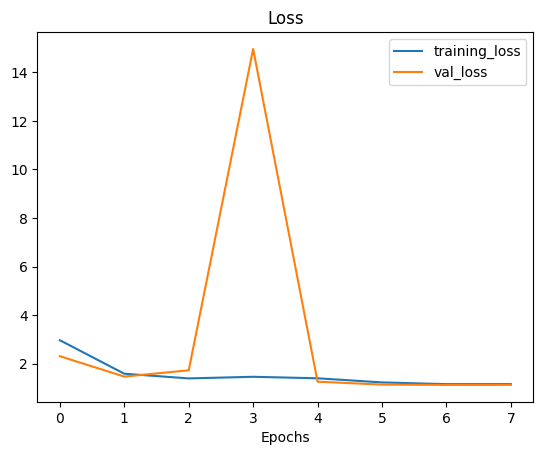

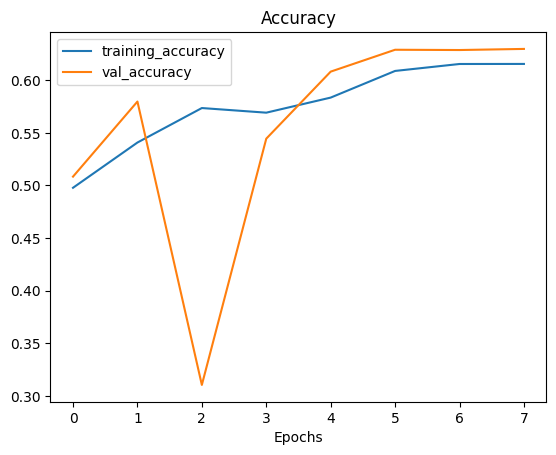

In [ ]:
# Fit the model with callbacks and fine-tuning
history = rmodel.fit(train_generator,
                     steps_per_epoch=len(train_generator),
                     epochs=8,
                     validation_data=validation_generator,
                     validation_steps=len(validation_generator),
                     callbacks=[early_stopping, learning_rate_scheduler])
# Evaluate the trained model
test_loss, test_accuracy = rmodel.evaluate(test_generator)
print(f'New test loss: {test_loss}')
print(f'New test accuracy: {test_accuracy}')

# Ploting the loss curve
plot_loss_curves(history)
# Getting the predictions for the test set
predictions = rmodel.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Printing the classification report
print('Classification Report:')
print(classification_report(y_true, y_pred))

# Calculating and displaying precision, recall, and confusion matrix
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)
# Save the trained model to Google Drive
rmodel.save('/Users/KIIT/Documents/skin_class/Res152Classificationf8.h5')

Class Names from the test directory:
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
119/119 [==============================] - 483s 4s/step


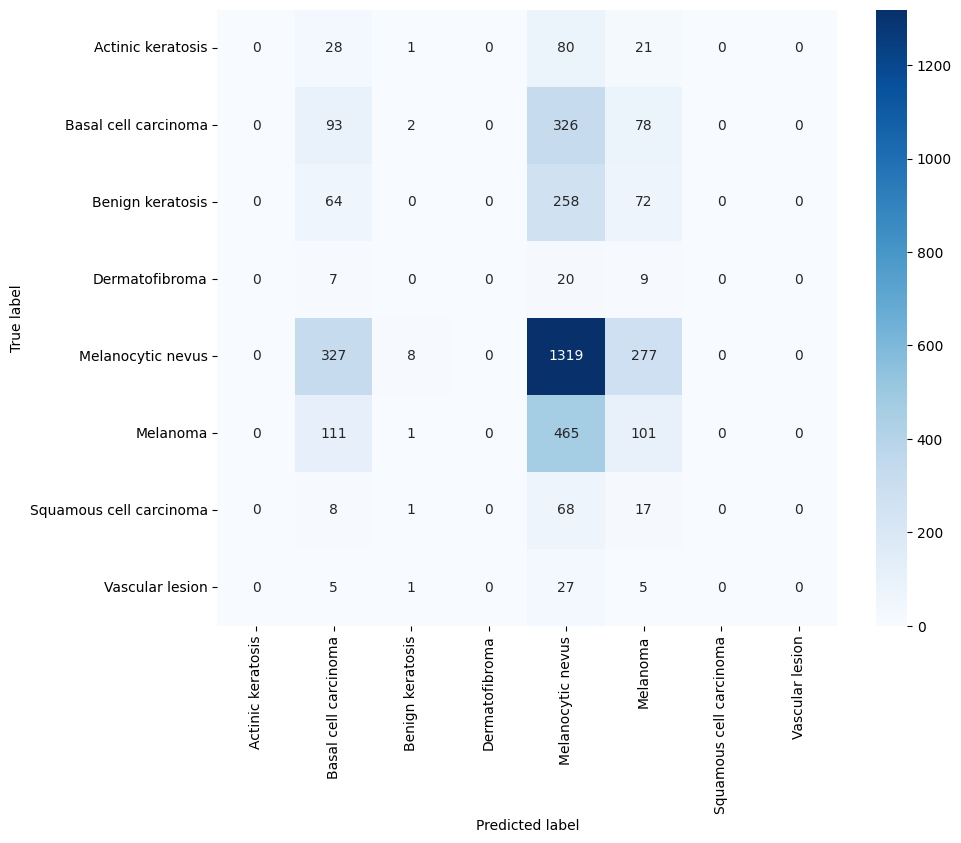

In [ ]:
#Confusion matrix with heatmap
class_names = list(test_generator.class_indices.keys())
print("Class Names from the test directory:")
print(class_names)
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Loading the saved model
model_1 = load_model('/Users/KIIT/Documents/skin_class/Res152Classificationf8.h5')
# Getting the predictions for the test set
predictions_1 = model_1.predict(test_generator)
y_pred_1 = np.argmax(predictions_1, axis=1)
y_true_1 = test_generator.classes

# Generating the confusion matrix
confusion = confusion_matrix(y_true_1, y_pred_1)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Class Names from the test directory:
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


119/119 [==============================] - 163s 1s/step - loss: 0.8571 - accuracy: 0.7126
New test loss: 0.8570671677589417
New test accuracy: 0.7126315832138062
119/119 [==============================] - 163s 1s/step


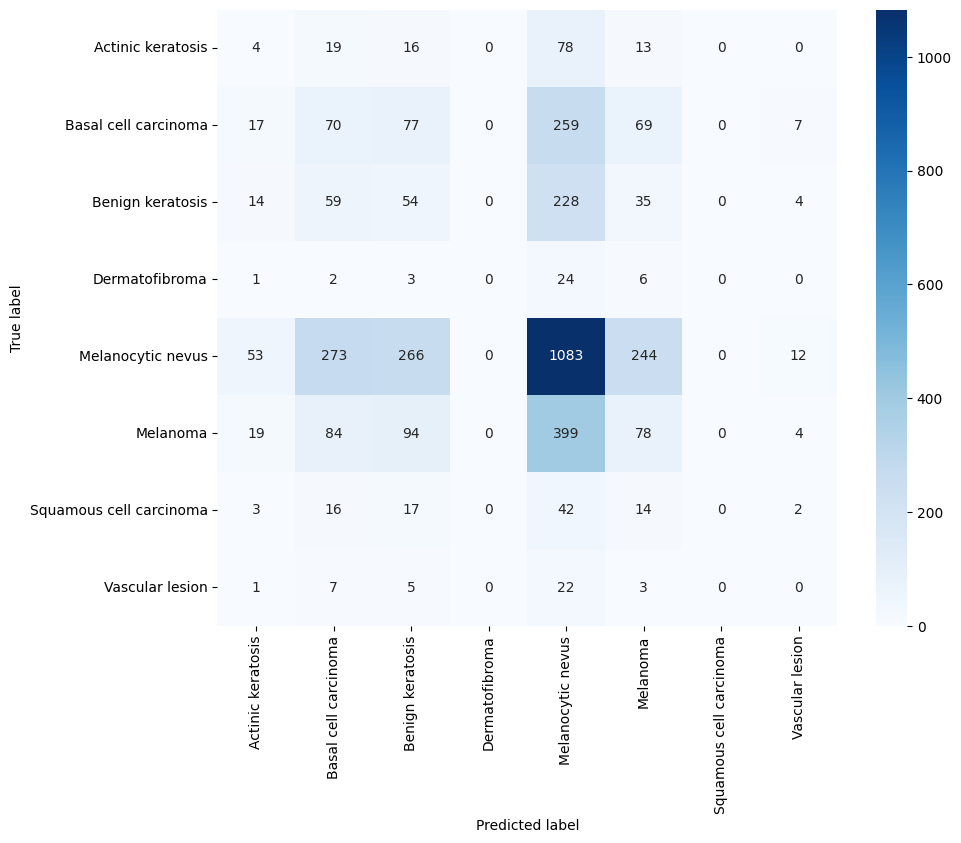

In [ ]:
#Confusion matrix with heatmap
class_names = list(test_generator.class_indices.keys())
print("Class Names from the test directory:")
print(class_names)
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Load the saved model
model_3 = load_model('/Users/KIIT/Documents/skin_class/DenseNet121Classification_project15.h5')
# Evaluate the retrained model
test_loss, test_accuracy = model_3.evaluate(test_generator)
print(f'New test loss: {test_loss}')
print(f'New test accuracy: {test_accuracy}')
# Get the predictions for the test set
predictions_3 = model_3.predict(test_generator)
y_pred_3 = np.argmax(predictions_3, axis=1)
y_true_3 = test_generator.classes

# Generate the confusion matrix
confusion = confusion_matrix(y_true_3, y_pred_3)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

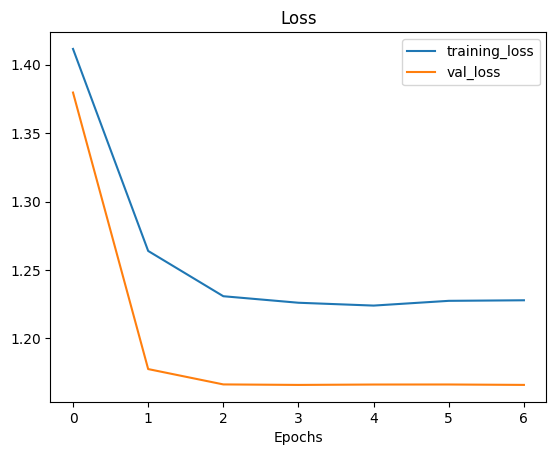

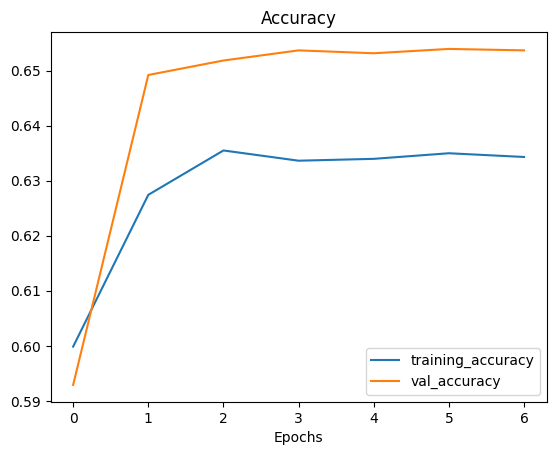

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load the saved model
l_model = load_model('/Users/KIIT/Documents/skin_class/VGG19Class7.h5')
l_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Update the loss function

# Learning rate scheduling function
def learning_rate_schedule(epoch, learning_rate):
    # if epoch <3:
    #     return learning_rate
    # else:
        return learning_rate * 0.1

# Define optimizer with initial learning rate
optimizer = Adam(learning_rate=0.0001)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate scheduler callback
learning_rate_scheduler = LearningRateScheduler(learning_rate_schedule)
# Print model summary
l_model.summary()

# Fit the model with callbacks
history = l_model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=7,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=[early_stopping, learning_rate_scheduler])
# Evaluate the retrained model
test_loss, test_accuracy = l_model.evaluate(test_generator)
print(f'New test loss: {test_loss}')
print(f'New test accuracy: {test_accuracy}')

# Plot the loss curve
plot_loss_curves(history)
# Get the predictions for the test set
predictions =l_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred))

# Calculate and display precision, recall, and confusion matrix
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Compute and display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)
# Save the retrained model to Google Drive
l_model.save('/Users/KIIT/Documents/skin_class/VGG19Class14.h5')

Class Names from the test directory:
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
119/119 [==============================] - 2424s 20s/step


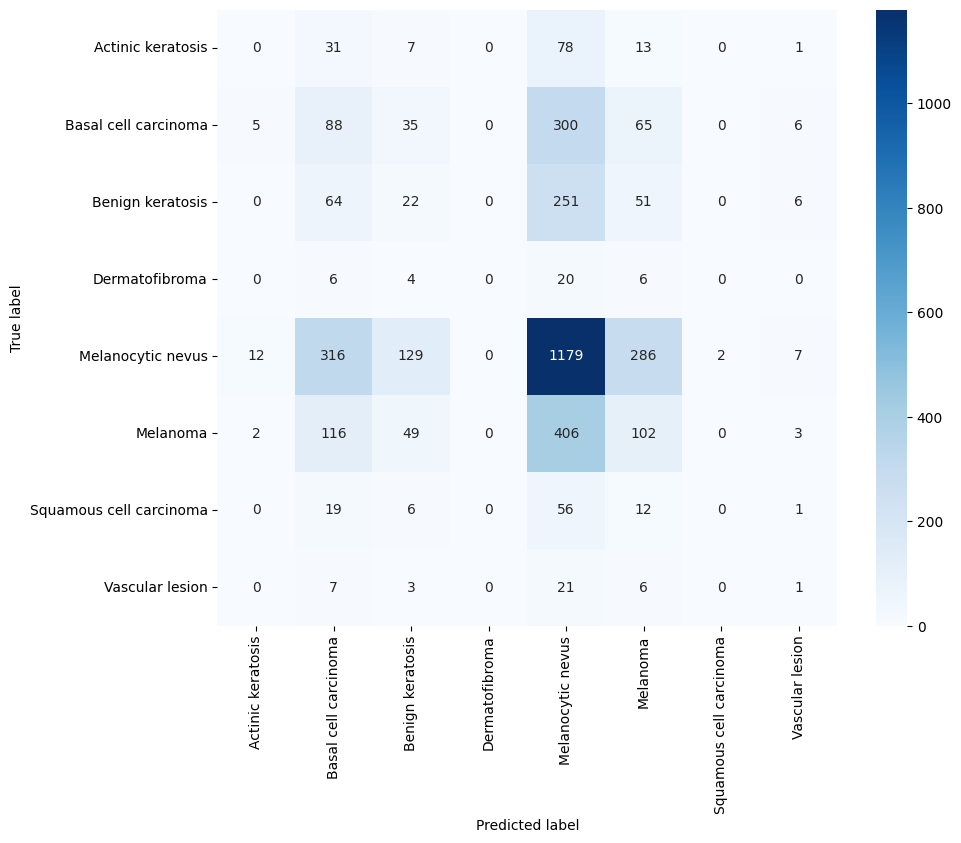

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
class_names = list(test_generator.class_indices.keys())
print("Class Names from the test directory:")
print(class_names)
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
# Load the saved model
model_1 = load_model('/Users/KIIT/Documents/skin_class/VGG19Class14.h5')
# Get the predictions for the test set
predictions_1 = model_1.predict(test_generator)
y_pred_1 = np.argmax(predictions_1, axis=1)
y_true_1 = test_generator.classes

# Generate the confusion matrix
confusion = confusion_matrix(y_true_1, y_pred_1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Class Names from the test directory:
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
119/119 [==============================] - 1792s 15s/step


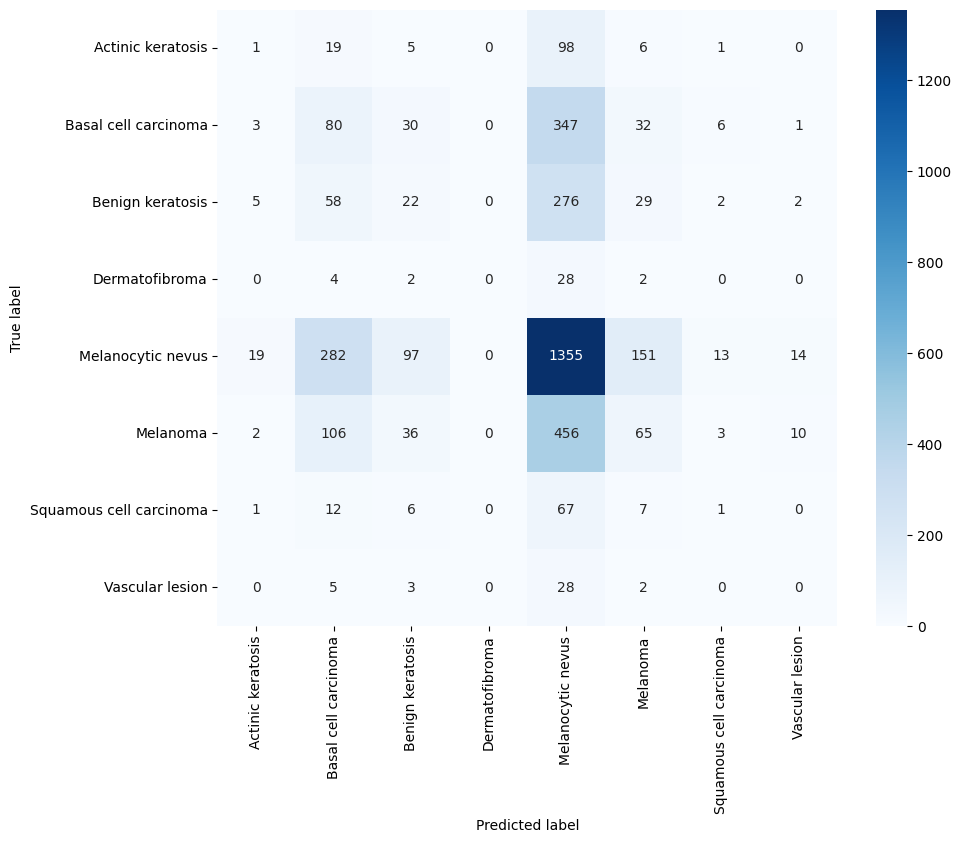

In [ ]:
class_names = list(test_generator.class_indices.keys())
print("Class Names from the test directory:")
print(class_names)
['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/Users/KIIT/Documents/skin_class/Classification_project30.h5')
# Get the predictions for the test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()